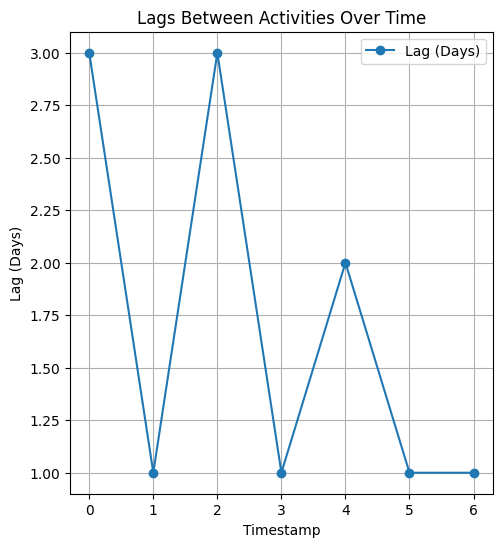

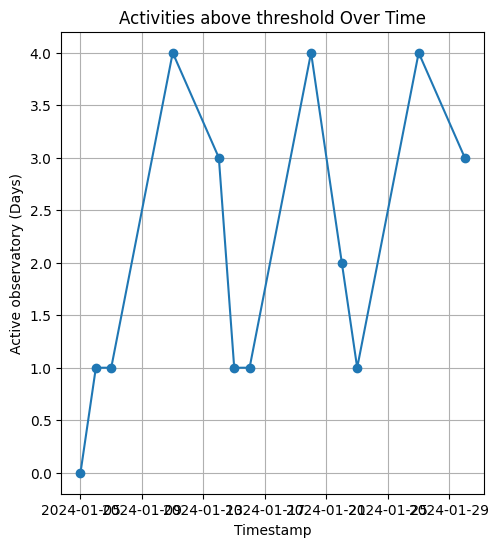

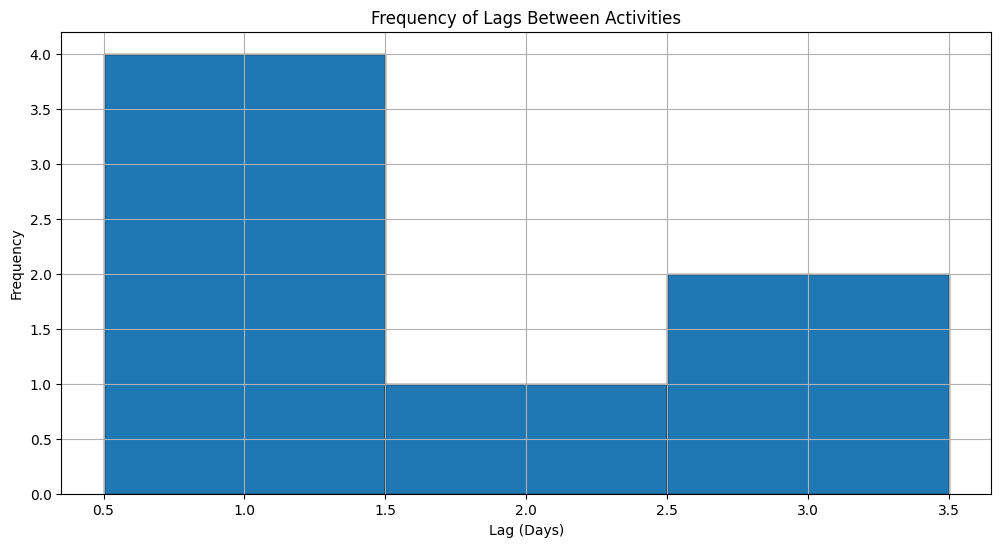

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def generate_synthetic_transaction_data():
    # Seed for reproducibility
    np.random.seed(42)

    # Generate synthetic data
    num_days = 30
    rate_of_no_activity = 0.3 # 30% zeros indicating no activity
    rate_of_activity = 1 - rate_of_no_activity

    start_date = datetime(2024, 1, 1)
    timestamps = [start_date + timedelta(days=i) for i in range(num_days)]
    activities = np.random.choice([0, 1], size=num_days, p=[rate_of_no_activity, rate_of_activity])

    ts_data = pd.DataFrame({
        'timestamp': timestamps,
        'activity': activities
    })

    return ts_data

# Calculate lags between activities
def trace_lags_between_activities(data, threshold=1):
    data['lag'] = data['timestamp'].diff().dt.days
    data['lag'] = data['lag'].fillna(0)  # Replace NaN with 0 for the first entry

    # Identify periods of inactivity
    inactivity_periods = []
    current_inactivity = 0

    for index, row in data.iterrows():
        if row['activity'] < threshold:
            current_inactivity += 1
        else:
            if current_inactivity > 0:
                inactivity_periods.append(current_inactivity)
            current_inactivity = 0

    # Append the last inactivity period if it exists
    if current_inactivity > 0:
        inactivity_periods.append(current_inactivity)

    return inactivity_periods

# Truncate activities below the threshold
def trace_activities_above_or_equal_to_threshold(data, threshold=1):
    # Filter out activities above the threshold
    filtered_data = data[data['activity'] < threshold].copy()

    # Calculate lags between the remaining activities
    filtered_data['activity'] = filtered_data['timestamp'].diff().dt.days
    filtered_data['activity'] = filtered_data['activity'].fillna(0)  # Replace NaN with 0 for the first entry

    return filtered_data

# plot
import matplotlib.pyplot as plt

def plot_(ts_data, lags, ts_data_above_or_equal_threshold):
    # Plot the delays (lags)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(lags, marker='o', linestyle='-', label='Lag (Days)')
    plt.title('Lags Between Activities Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Lag (Days)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 2)
    plt.plot(ts_data_above_or_equal_threshold['timestamp'], ts_data_above_or_equal_threshold['activity'], marker='o', linestyle='-', label='Active Observatory (Days)')
    plt.title('Activities above threshold Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Active observatory (Days)')
    plt.grid(True)
    plt.show()

    # Ensure lags are integers
    lags = np.array(lags)

    # Plot the frequency of lags
    plt.figure(figsize=(12, 6))
    plt.hist(lags, bins=range(1, max(lags)+2), align='left', edgecolor='black')
    plt.title('Frequency of Lags Between Activities')
    plt.xlabel('Lag (Days)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


# Usage
ts_data = generate_synthetic_transaction_data()
# print(ts_data)
inactivity_periods = trace_lags_between_activities(ts_data)
#print(f"Lags between activities: {inactivity_periods}")
ts_data_above_or_equal_threshold = trace_activities_above_or_equal_to_threshold(ts_data, threshold=1) # to be debugged
#print(f"ts_data_above_or_equal_threshold: {ts_data_above_or_equal_threshold}")

plot_(ts_data, inactivity_periods, ts_data_above_or_equal_threshold)

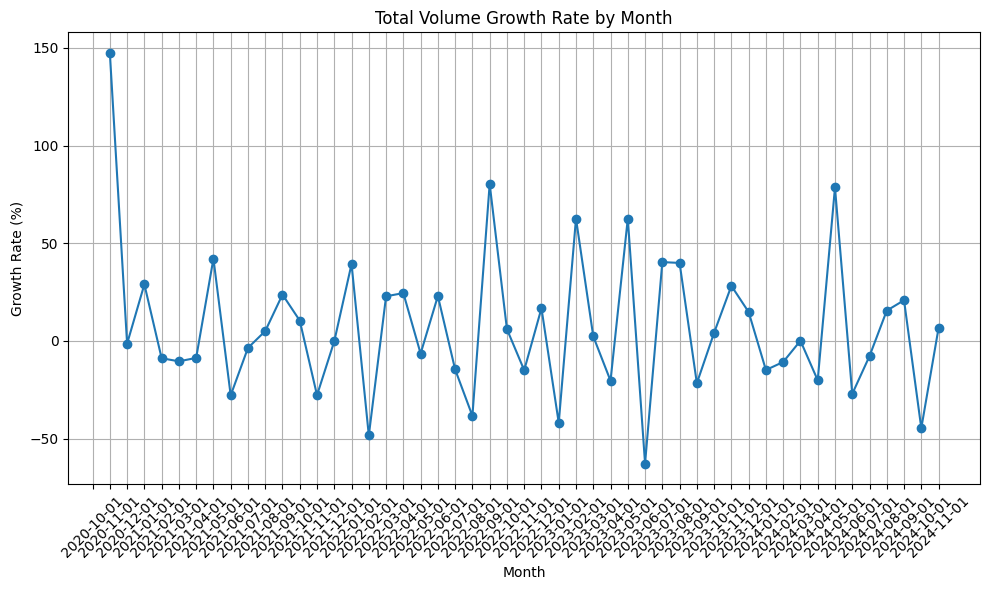

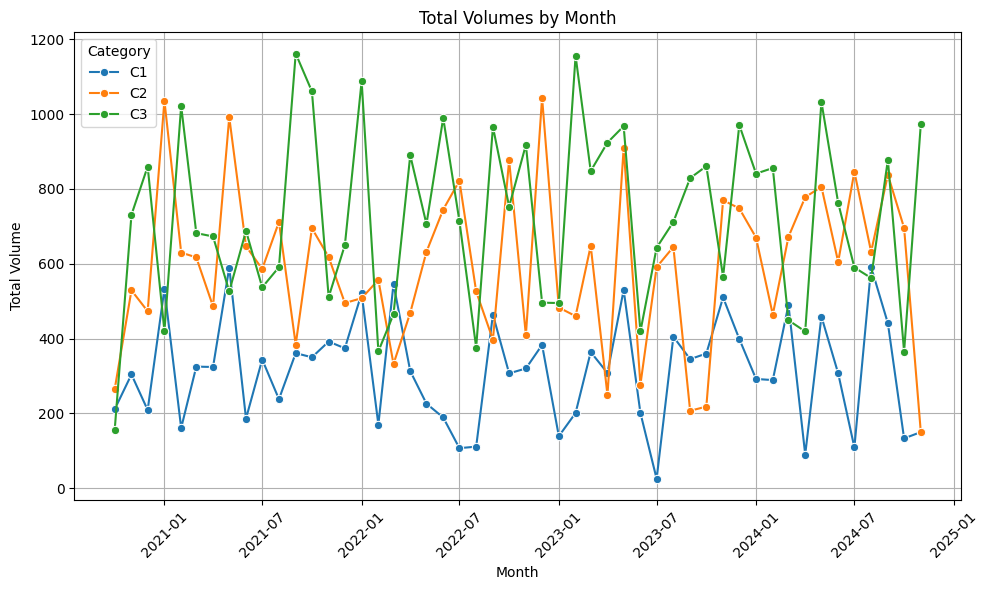

Number of occurrences of C1: 296
Number of occurrences of C2: 555


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random

# Simulate data
np.random.seed(0)  # for reproducibility
data_length = 1500
# Generate random dates for the last 2 years
# start_date = datetime.now() - timedelta(days=2 * 365)
start_date = datetime.now() - timedelta(days=data_length)

end_date = datetime.now()

dates = pd.date_range(start_date, end_date, periods=data_length)
dates = np.random.choice(dates, size=data_length)

channels = np.random.choice(['A', 'B', 'C'], size=data_length)   # Generate random channels
volumes = np.random.randint(10, 100, size=data_length)           # Generate random volumes

# Create DataFrame
df = pd.DataFrame({
    'Date': dates,
    'Channel': channels,
    'Volume': volumes
})

# Map channels to categories
channel_mapping = {
    'A': 'C1',
    'B': 'C2',
    'C': 'C3'
}

# Define categories and shuffle them
categories = ['C1', 'C2', 'C3']
random.shuffle(categories)

# Map channels to shuffled categories
#channel_mapping = {
#    'A': categories[0],
#    'B': categories[1],
#    'C': categories[2]
#}

# Assign random categories to each row with different probability
df['Category'] = np.random.choice(categories, size=df.shape[0], p=[0.35, 0.2, 0.45])
#df['Category'] = df['Channel'].map(channel_mapping)

# Aggregate by month
df['Month'] = df['Date'].dt.to_period('M')
monthly_data = df.groupby(['Month', 'Category']).agg({'Volume': 'sum'}).reset_index() # add by month (priority category)
# Assuming 'Month' is not already datetime (if it's period, convert it to datetime)
monthly_data['Month'] = monthly_data['Month'].dt.to_timestamp()

# Calculate growth/decline rate by month
monthly_pivot = monthly_data.pivot(index='Month', columns='Category', values='Volume').fillna(0)
monthly_pivot['Total'] = monthly_pivot.sum(axis=1)
monthly_pivot['Total_Growth_Rate'] = monthly_pivot['Total'].pct_change() * 100

# Drop the first row (since pct_change() will be NaN for the first row)
# Convert Period index to string for plotting
monthly_pivot.index = monthly_pivot.index.astype(str)

# Plot growth rate
plt.figure(figsize=(10, 6))
plt.plot(monthly_pivot.index, monthly_pivot['Total_Growth_Rate'], marker='o', linestyle='-')
plt.title('Total Volume Growth Rate by Month')
plt.xlabel('Month')
plt.ylabel('Growth Rate (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot total volumes by month
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_data, x='Month', y='Volume', hue='Category', marker='o')
plt.title('Total Volumes by Month')
plt.xlabel('Month')
plt.ylabel('Total Volume')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Count the occurrences of each category
category_counts = df['Category'].value_counts()
# Get the count for 'C'
c1_count = category_counts.get('C1', 0)  # Use .get to avoid KeyError if 'C1' is not present
print(f"Number of occurrences of C1: {c1_count}")
c2_count = category_counts.get('C2', 0)  # Use .get to avoid KeyError if 'C2' is not present
print(f"Number of occurrences of C2: {c2_count}")

result = monthly_pivot['Total']
# print(f'monthly_pivot\[\'Total\'\]: {result}')

    user_id           timestamp      amount currency   latitude   longitude
45        1 2024-01-03 22:10:40  651.213219      USD -74.637456   91.635435
41        1 2024-01-06 13:28:40  130.867075      EUR   4.003787  155.072637
87        1 2024-01-06 16:31:10  513.116789      USD  -4.775081  175.190248
94        1 2024-01-07 05:33:52  355.179327      JPY -22.569729  -44.546549
70        1 2024-01-08 05:02:11  351.620536      USD  81.875751 -159.278846


<ipython-input-3-dea0c6ad254e>:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.0037367833597152064, 0.04154850843806587, 0.0022242667545144413, 0.004462893876569943, 0.0031757152717972314, 0.015198090949480464, 0.027311229808745403, 0.0029662487777339136, 0.007274809543024284, 0.001726882033420552, 0.002766268916980803, 0.032280306928199776, 0.00473095228611967, 0.003026323203789548, 0.0010638348602065061, 0.001143917998011822, 0.0033435620339480887]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[user_data.index[1:], 'velocity'] = velocities
<ipython-input-3-dea0c6ad254e>:82: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0, 3.4531255779315676e-06, -8.373630101688904e-07, 2.649294218932179e-08, -6.0815226963473966e-09, 2.730124370443099e-07, 5.556485715259146e-07, -2.5

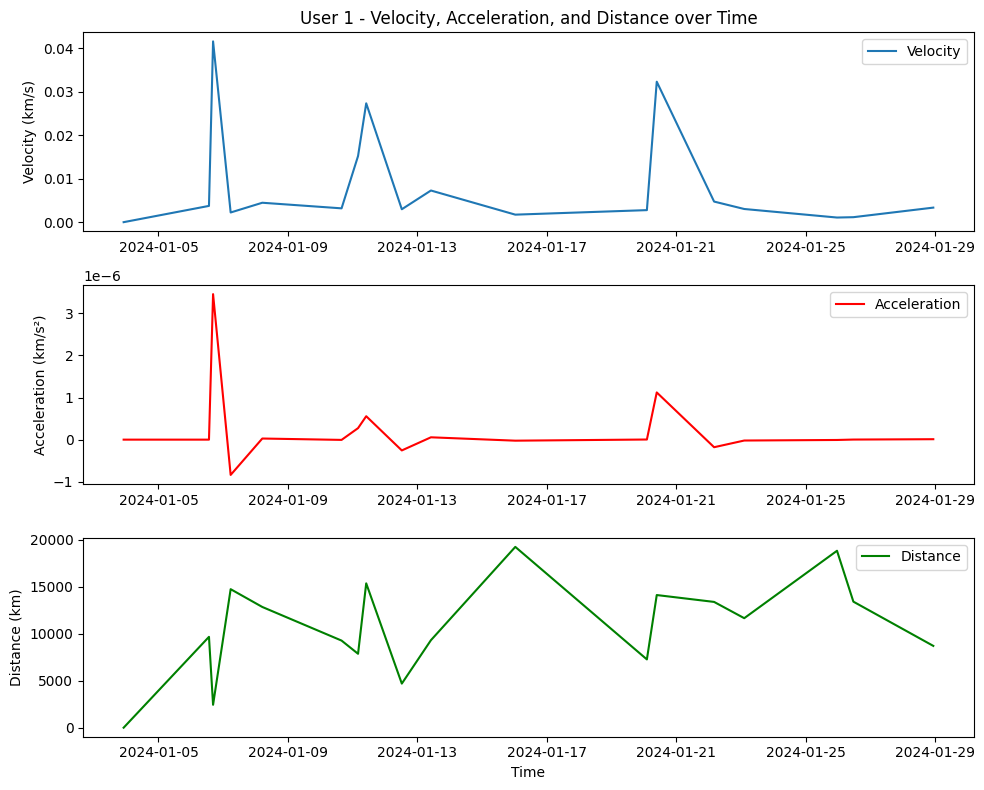

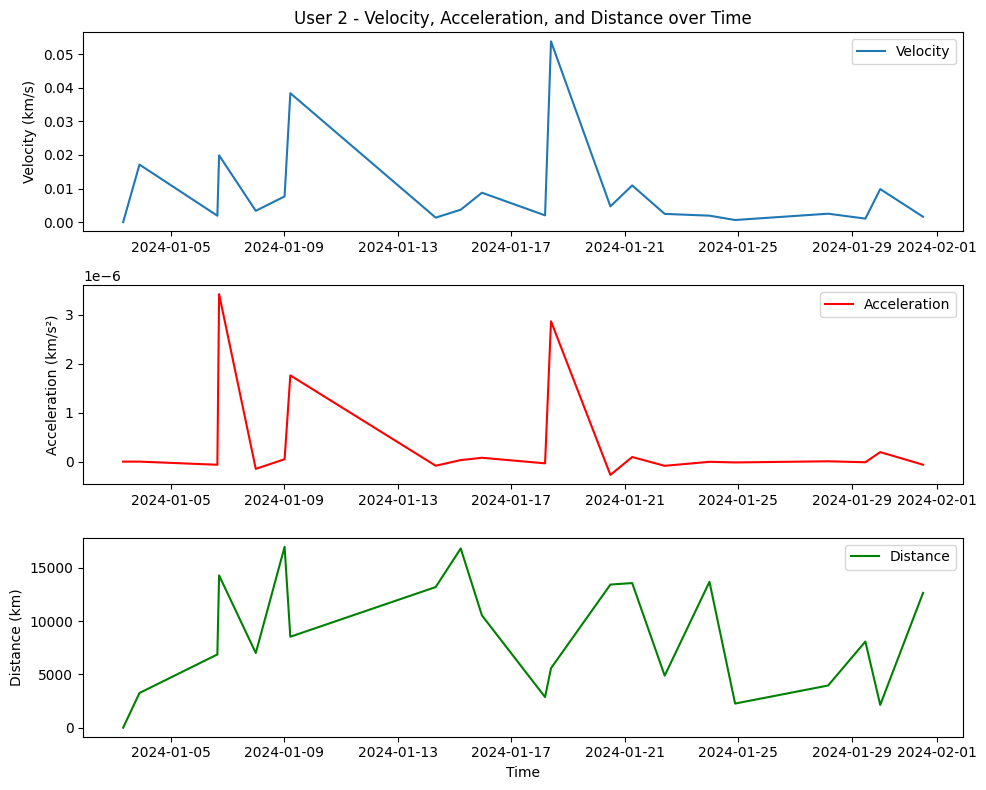

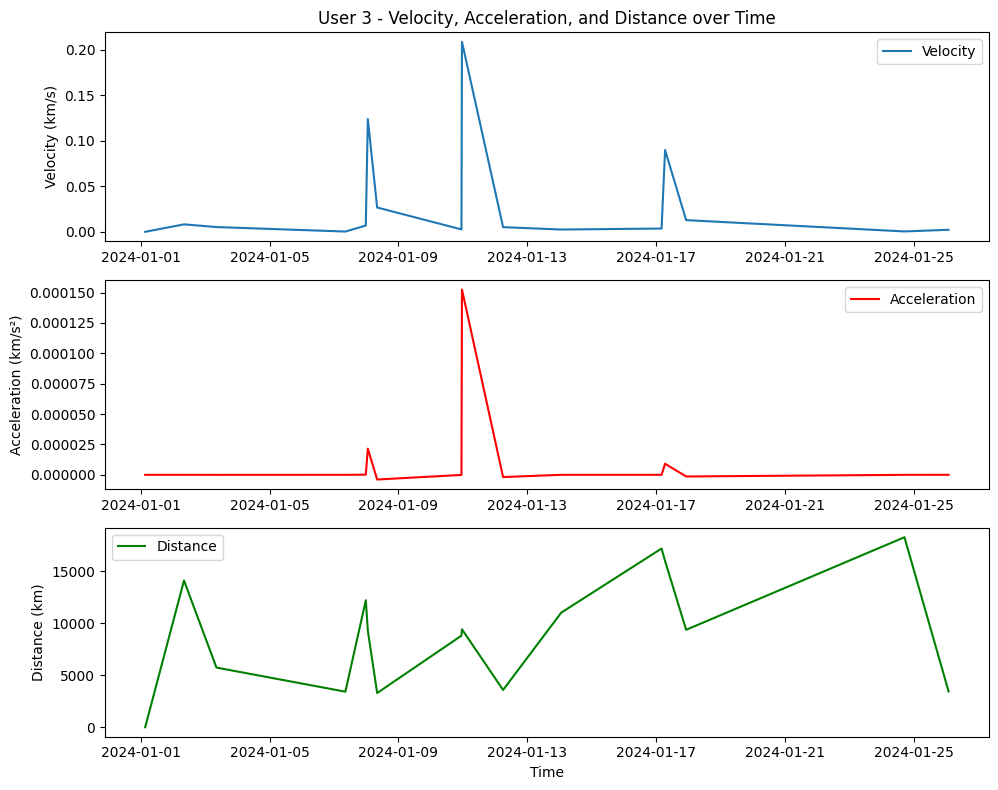

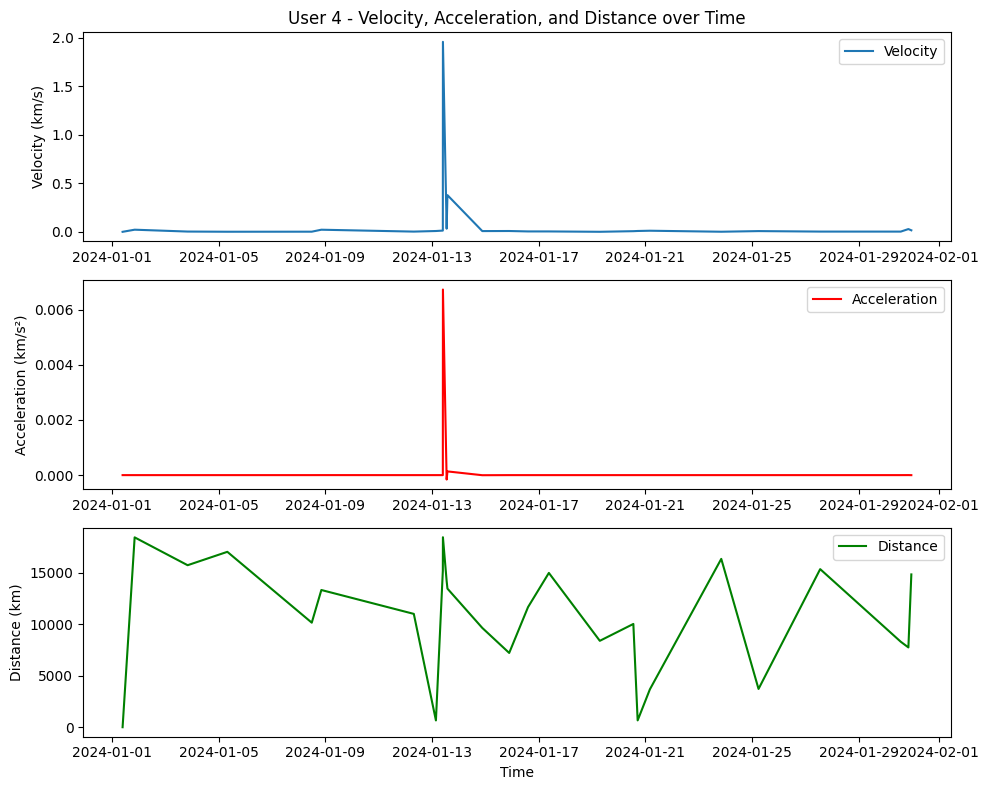

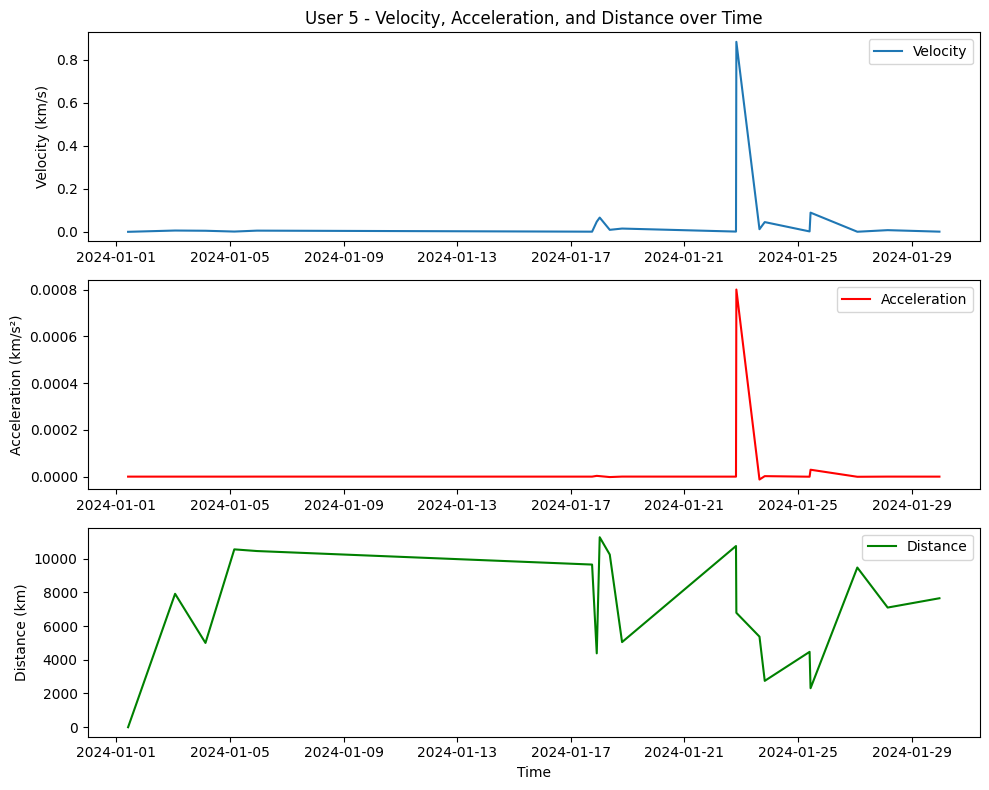

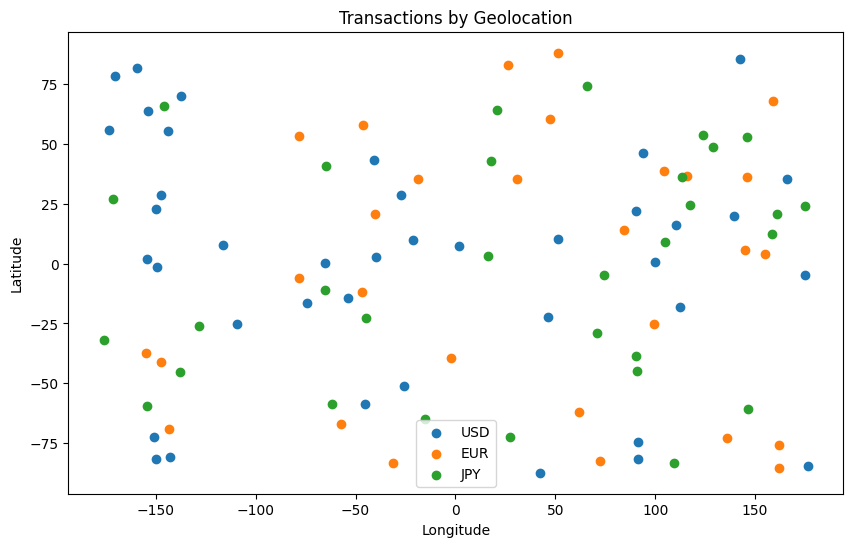

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# Function to generate synthetic transaction data
def generate_synthetic_transaction_data():
    # Seed for reproducibility
    np.random.seed(42)
    random.seed(42)

    # Generate synthetic data
    num_users = 5
    num_transactions = 100
    start_date = datetime(2024, 1, 1)

    data = {
        'user_id': np.random.choice(range(1, num_users+1), num_transactions),
        'timestamp': [start_date + timedelta(days=random.randint(0, 30), seconds=random.randint(0, 86400)) for _ in range(num_transactions)],
        'amount': np.random.uniform(10, 1000, num_transactions),
        'currency': np.random.choice(['USD', 'EUR', 'JPY'], num_transactions),
        'latitude': np.random.uniform(-90, 90, num_transactions),
        'longitude': np.random.uniform(-180, 180, num_transactions)
    }

    df = pd.DataFrame(data)
    df.sort_values(by=['user_id', 'timestamp'], inplace=True)
    print(df.head())

    return df

# Function to save DataFrame to CSV
def dataFrame_to_CSV(dataFrame, csv_file_path):
    # Save the DataFrame to a CSV file
    dataFrame.to_csv(csv_file_path, index=False)

# Function to read CSV into DataFrame
def CSV_to_dataFrame(csv_file_path):
    # Read the CSV file back into a DataFrame
    df_read_back = pd.read_csv(csv_file_path, parse_dates=['timestamp'])
    print(df_read_back.head())
    return df_read_back

# Function to calculate velocity, acceleration, and distance
def calculate_velocity_acceleration_distance(df):
    df['velocity'] = 0
    df['acceleration'] = 0
    df['distance'] = 0

    for user_id in df['user_id'].unique():
        user_data = df[df['user_id'] == user_id].sort_values('timestamp')
        velocities = []
        accelerations = []
        distances = []

        for i in range(1, len(user_data)):
            # Calculate time difference in seconds
            time_diff = (user_data.iloc[i]['timestamp'] - user_data.iloc[i-1]['timestamp']).total_seconds()
            if time_diff == 0:
                time_diff = 1  # Avoid division by zero

            # Calculate geodesic distance
            loc1 = (user_data.iloc[i-1]['latitude'], user_data.iloc[i-1]['longitude'])
            loc2 = (user_data.iloc[i]['latitude'], user_data.iloc[i]['longitude'])
            distance = geodesic(loc1, loc2).kilometers
            distances.append(distance)

            # Calculate velocity
            velocity = df['amount'][i] / time_diff  # When df['amount'][i] is used, we are computing the velocity of money
            velocities.append(velocity)

            if len(velocities) > 1:
                # Calculate acceleration
                acceleration = (velocities[-1] - velocities[-2]) / time_diff
                accelerations.append(acceleration)
            else:
                accelerations.append(0)

        df.loc[user_data.index[1:], 'velocity'] = velocities
        df.loc[user_data.index[1:], 'acceleration'] = accelerations
        df.loc[user_data.index[1:], 'distance'] = distances

    return df

# Function to plot graphs
def plot_graphs(df):
    # Plot velocity, acceleration, and distance over time for each user
    for user_id in df['user_id'].unique():
        user_data = df[df['user_id'] == user_id]
        plt.figure(figsize=(10, 8))

        plt.subplot(3, 1, 1)
        plt.plot(user_data['timestamp'], user_data['velocity'], label='Velocity')
        plt.title(f'User {user_id} - Velocity, Acceleration, and Distance over Time')
        plt.ylabel('Velocity (km/s)')
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(user_data['timestamp'], user_data['acceleration'], label='Acceleration', color='r')
        plt.ylabel('Acceleration (km/s²)')
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(user_data['timestamp'], user_data['distance'], label='Distance', color='g')
        plt.ylabel('Distance (km)')
        plt.xlabel('Time')
        plt.legend()

        plt.tight_layout()
        plt.show()

    # Plot transactions by geolocation
    plt.figure(figsize=(10, 6))
    for currency in df['currency'].unique():
        currency_data = df[df['currency'] == currency]
        plt.scatter(currency_data['longitude'], currency_data['latitude'], label=currency)

    plt.title('Transactions by Geolocation')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

# Example usage:
df = generate_synthetic_transaction_data()
df = calculate_velocity_acceleration_distance(df)
plot_graphs(df)


    user_id           timestamp      amount currency   latitude   longitude
45        1 2024-01-03 22:10:40  651.213219      USD -74.637456   91.635435
41        1 2024-01-06 13:28:40  130.867075      EUR   4.003787  155.072637
87        1 2024-01-06 16:31:10  513.116789      USD  -4.775081  175.190248
94        1 2024-01-07 05:33:52  355.179327      JPY -22.569729  -44.546549
70        1 2024-01-08 05:02:11  351.620536      USD  81.875751 -159.278846
   user_id           timestamp      amount currency   latitude   longitude
0        1 2024-01-03 22:10:40  651.213219      USD -74.637456   91.635435
1        1 2024-01-06 13:28:40  130.867075      EUR   4.003787  155.072637
2        1 2024-01-06 16:31:10  513.116789      USD  -4.775081  175.190248
3        1 2024-01-07 05:33:52  355.179327      JPY -22.569729  -44.546549
4        1 2024-01-08 05:02:11  351.620536      USD  81.875751 -159.278846
   user_id           timestamp      amount currency   latitude   longitude  \
0        1 2024-

<ipython-input-3-dea0c6ad254e>:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.0005742806527719266, 0.0468599807281563, 0.007563121830816662, 0.004161239015212205, 0.0007522199841523202, 0.018175167447876863, 0.005494583146959312, 0.005971353302159875, 0.005431948353632865, 0.0037251040966467604, 0.0016983890573593935, 0.0265158825417296, 0.0031055786297877024, 0.007802421152921112, 0.003303515416022827, 0.00403814180293132, 0.001068537088307559]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[user_data.index[1:], 'velocity'] = velocities
<ipython-input-3-dea0c6ad254e>:82: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0, 4.2270045730944636e-06, -8.367799262667612e-07, -4.0259444675137655e-08, -1.6106565579010484e-08, 3.9565236315116136e-07, -5.816781789411721e-07, 5.01

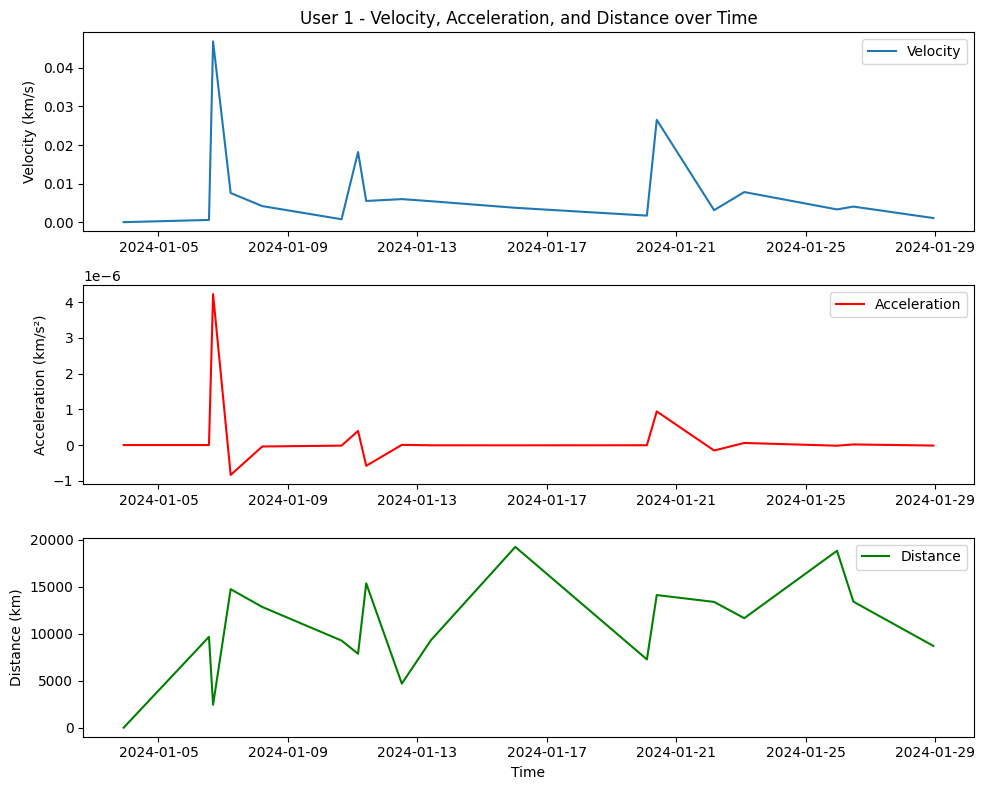

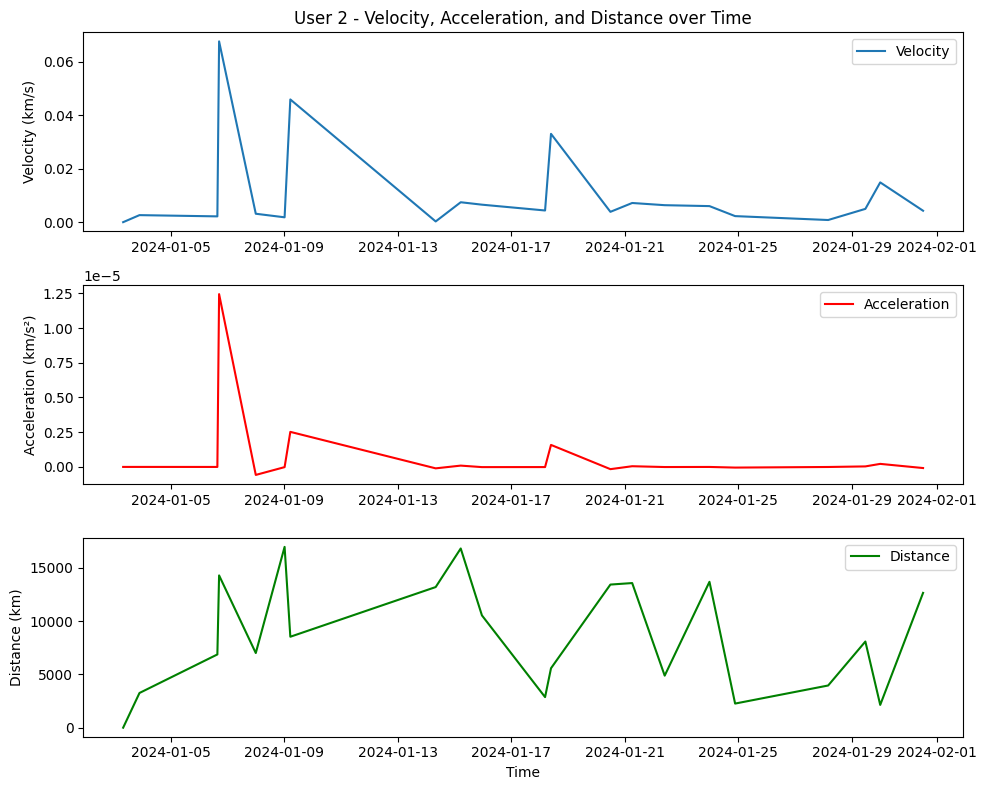

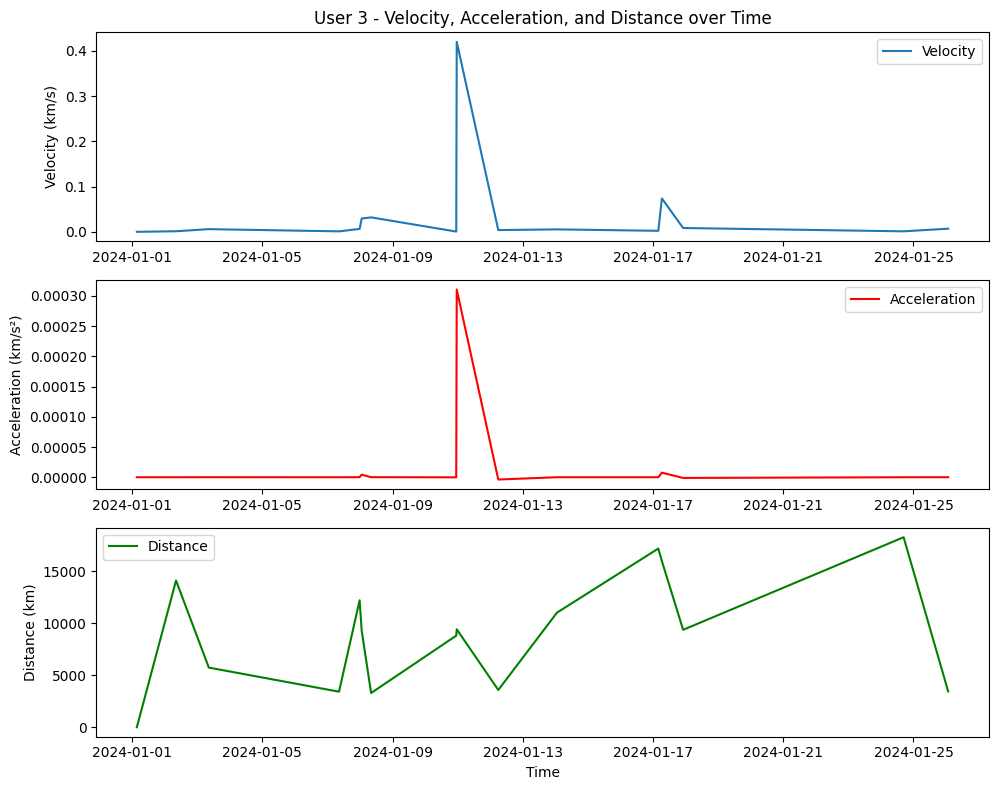

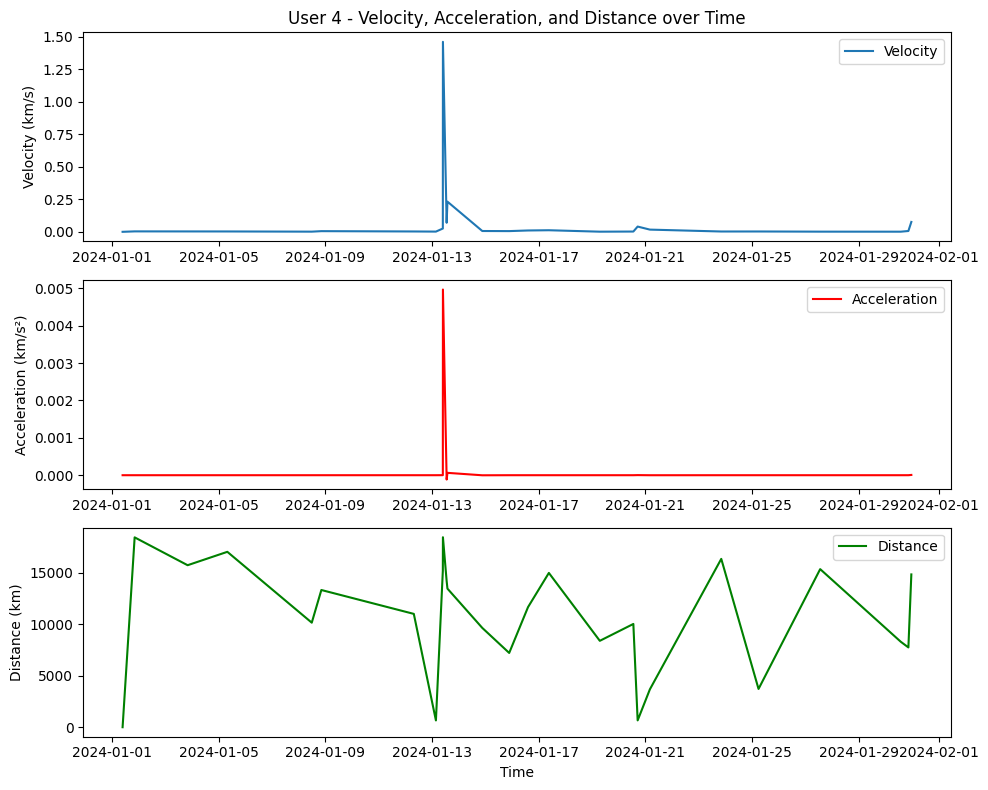

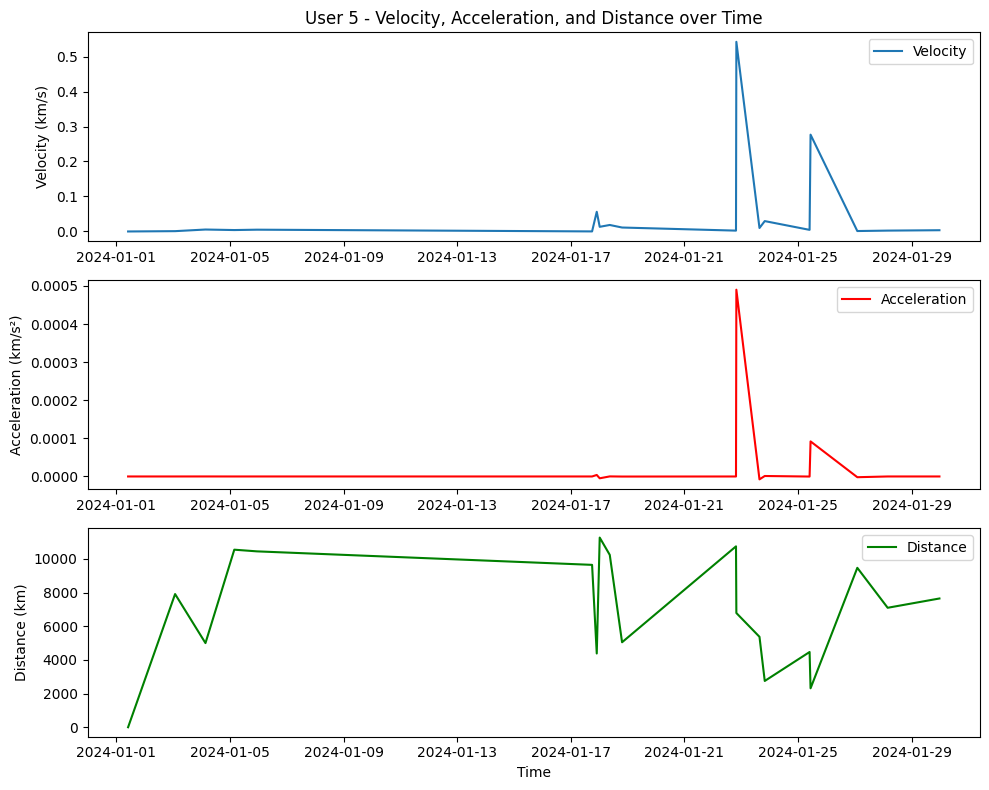

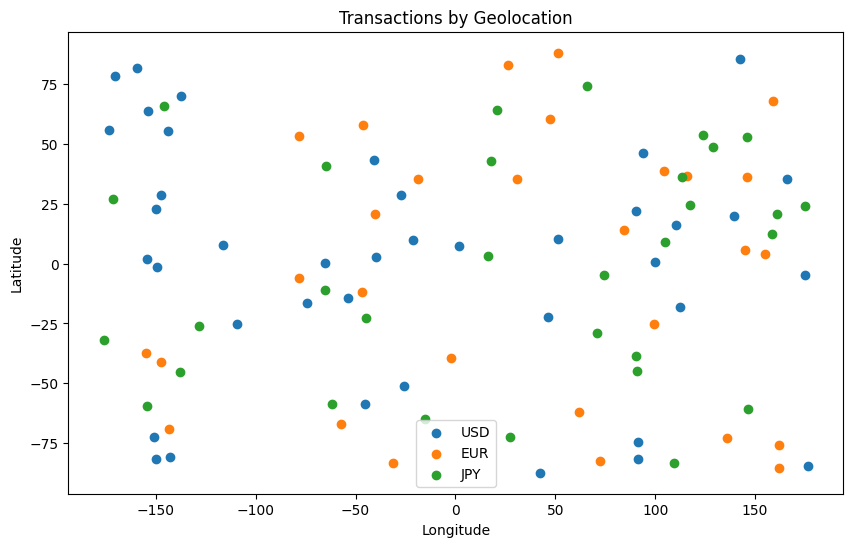

In [4]:
csv_file_path = './sample_data/synthetic_transactions.csv'

dataFrame = generate_synthetic_transaction_data()
dataFrame_to_CSV(dataFrame, csv_file_path)
dataFrame = CSV_to_dataFrame(csv_file_path)

df_attributes = calculate_velocity_acceleration_distance(dataFrame)
print(df_attributes.head())

plot_graphs(df_attributes)

In [5]:
dataFrame

last_N = -4
# Select all rows and the last_N columns
result = dataFrame.iloc[:, last_N:]

df_new = result.sample(10)

# extract to an array
import numpy as np

arr = np.array([df_new['longitude'],	df_new['velocity'],	df_new['acceleration'],	df_new['distance']])

# Select all rows and the last_N columns
result = arr[:, last_N:]
print(result)

"""
import pandas as pd

# Create a DataFrame with 3 rows and 6 columns
df = pd.DataFrame({
    'A': [1, 2, 3],
    'B': [4, 5, 6],
    'C': [7, 8, 9],
    'D': [10, 11, 12],
    'E': [13, 14, 15],
    'F': [16, 17, 18]
})

# Select all rows and the last 4 columns
result = df.iloc[:, -4:]
print(result)


import numpy as np

# Create a 3x6 numpy array
arr = np.array([[ 1,  2,  3,  4,  5,  6],
                [ 7,  8,  9, 10, 11, 12],
                [13, 14, 15, 16, 17, 18]])

# Select all rows and the last 4 columns
result = arr[:, -4:]
print(result)
"""
df_new


[[ 5.12709402e+01 -7.85322811e+01  1.12607844e+02  1.04262531e+02]
 [ 0.00000000e+00  6.91817206e-03  2.21862339e-03  2.26180003e-03]
 [ 0.00000000e+00  4.94161551e-08 -1.17812134e-08 -4.78926896e-08]
 [ 0.00000000e+00  3.44241580e+03  1.71753964e+04  2.26252801e+03]]


,longitude,velocity,acceleration,distance
3,-44.546549,0.007563,-8.367799e-07,14748.919602
33,90.313584,0.006001,-2.534595e-09,13688.459582
65,-2.008690,0.069568,-1.153612e-04,14200.023315
45,-170.455928,0.031952,1.041845e-07,3287.487170
40,90.221311,0.001258,0.000000e+00,14099.244774
85,-53.670595,0.005110,1.539642e-08,10446.056794
81,51.270940,0.000000,0.000000e+00,0.000000
54,-78.532281,0.006918,4.941616e-08,3442.415796
50,112.607844,0.002219,-1.178121e-08,17175.396431
34,104.262531,0.002262,-4.789269e-08,2262.528009


In [6]:
dataFrame.columns.values.tolist() # show headers
# dataFrame.sort_values('distance')
# dataFrame.sort_values('velocity', ascending=False)
# Sorting by columns "velocity" and then "amount"
# dataFrame.sort_values(['velocity', 'amount'], ascending=False) # or dataFrame.sort_values('amount', ascending=False).sort_values('velocity', ascending=False)
# Sorting by columns "velocity" in descending, order and then "amount" in ascending order
dataFrame.sort_values(by=['velocity', 'amount'],
               ascending=[False, True])

,user_id,timestamp,amount,currency,latitude,longitude,velocity,acceleration,distance
64,4,2024-01-13 09:49:42,173.009295,JPY,24.737382,117.524688,1.461401,0.004969,18458.628284
92,5,2024-01-22 19:51:22,377.110070,JPY,12.611011,158.482887,0.542025,0.000490,6784.023901
47,3,2024-01-10 23:15:48,714.038037,JPY,24.316857,174.960383,0.420165,0.000311,9413.790143
96,5,2024-01-25 10:32:10,114.439317,USD,16.349987,110.460506,0.276722,0.000092,2312.770329
66,4,2024-01-13 13:53:39,90.044793,USD,46.412300,94.143827,0.232026,0.000063,13466.783152
...,...,...,...,...,...,...,...,...,...
18,2,2024-01-03 07:40:53,562.520982,EUR,-75.877851,162.022308,0.000000,0.000000,0.000000
39,3,2024-01-01 03:24:40,595.384810,EUR,88.209693,51.583759,0.000000,0.000000,0.000000
0,1,2024-01-03 22:10:40,651.213219,USD,-74.637456,91.635435,0.000000,0.000000,0.000000
55,4,2024-01-01 09:35:22,698.854679,USD,-58.823663,-45.262514,0.000000,0.000000,0.000000


In [ ]:
"""
Example: Data feeds
"""
#!pip install feedparser
import feedparser

# Parsing the feed
url = "https://timesofindia.indiatimes.com/rssfeedstopstories.cms" # "https://www.example.com/rss"
feed = feedparser.parse(url) # Parsing a specific RSS feed

# Printing all key-value pairs of the feed object
print("Feed key-value pairs:")
for key, value in feed.items():
    print(f"{key}: {value}")
print()

# Selecting a specific entry (e.g., the second entry in the feed)
entry = feed.entries[1]

# Printing all keys of the entry
print("Entry keys:")
print(entry.keys())
print()

# Printing details of the entry
print('Number of RSS posts:', len(feed.entries))
print('Post Title:', entry.title)
print(entry.published)
print("******")
print(entry.summary)
print("------News Link--------")
print(entry.link)
print()

# Printing all key-value pairs of the entry object
print("Entry key-value pairs:")
for key, value in entry.items():
    print(f"{key}: {value}")

if feed.status == 200:
    for entry in feed.entries:
        print(entry.title)
        print(entry.link)
else:
    print("Failed to get RSS feed. Status code:", feed.status)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 1.9 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=813cb549dafaf11a7ddbcd1aa2f9fb3bdb6602831bfa6329397e653c3f849b33
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k
Feed key-value pairs:
bozo: False
entries: [{'title': "Resort politics, tussle over CM post: How NDA, INDIA bloc are gearing up for Maha, J'khand mandate", 'title_detail': {'type': 'text/plain', 'language': 'en-IN', 'base': 'https://timesofindia.indiatimes.com/rssfeedstopstories.cms', 'value': "Resort politics, tussle over CM post: How NDA, INDIA bloc are gearing up for Maha, J'khand mandate"}, 'summary': 'As Maharashtra and Jharkhand await election results, both the BJP-led NDA and the opposition INDIA bloc are preparing for potential post-poll scenarios, including the possibility o